<a href="https://colab.research.google.com/github/dwu12/Machine-Learning-Project/blob/main/BLIP2_VQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 92.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from datasets import load_dataset

dataset = load_dataset("flaviagiammarino/vqa-rad")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1793 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/451 [00:00<?, ? examples/s]

In [ ]:
dataset['train']

Dataset({
    features: ['image', 'question', 'answer'],
    num_rows: 1793
})

In [ ]:
train_dataset = dataset["train"].select(range(0,1500))
val_dataset = dataset["train"].select(range(1500,1793))

print(len(train_dataset))
print(len(val_dataset))

1500
293


In [ ]:
from transformers import Blip2ForConditionalGeneration, Blip2Processor

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", device_map="auto", load_in_8bit=True)

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


pytorch_model.bin.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
import torch

In [ ]:
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, data, processor):
        self.data = data
        self.questions = data['question']
        self.answers = data['answer']
        self.processor = processor
        self.max_length = 32

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        answers = self.answers[idx]
        questions = self.questions[idx]
        image = self.data['image'][idx].convert('RGB')

        image_encoding = self.processor(images=image, padding="max_length", do_resize = True, size = (224,224) , return_tensors="pt")
        encoding = self.processor(None, questions, padding = 'max_length', truncation = True, max_length = self.max_length, return_tensors= 'pt')
        # # remove batch dimension
        for k,v in encoding.items():
            encoding[k] = v.squeeze()
        encoding["pixel_values"] = image_encoding["pixel_values"][0]

        # # add labels
        labels = self.processor.tokenizer.encode(answers, padding = 'max_length', truncation = True, max_length = self.max_length, return_tensors= 'pt')[0]
        encoding["labels"] = labels

        return encoding


In [ ]:
train_vqa_dataset = VQADataset(data=train_dataset, processor=processor)
val_vqa_dataset = VQADataset(data=val_dataset, processor=processor)

In [ ]:
for k,v in train_vqa_dataset[0].items():
    print(k, v.shape)

input_ids torch.Size([32])
attention_mask torch.Size([32])
pixel_values torch.Size([3, 224, 224])
labels torch.Size([32])


In [ ]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    # create new batch
    batch = {}
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['pixel_values'] = torch.stack(pixel_values)
    batch['labels'] = torch.stack(labels)

    return batch

In [ ]:
from datasets import load_dataset
from torch.utils.data import DataLoader

In [ ]:
train_dataloader = DataLoader(train_vqa_dataset, collate_fn=collate_fn, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_vqa_dataset, collate_fn=collate_fn, batch_size=64, shuffle=False)

In [ ]:
batch = next(iter(val_dataloader))
for k,v in batch.items():
    print(k, v.shape)

input_ids torch.Size([64, 32])
attention_mask torch.Size([64, 32])
pixel_values torch.Size([64, 3, 224, 224])
labels torch.Size([64, 32])


In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 5,242,880 || all params: 3,749,922,816 || trainable%: 0.13981301102065136


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

Question:  </s>do you see fluid in the left lung?<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Answer:  </s>yes<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


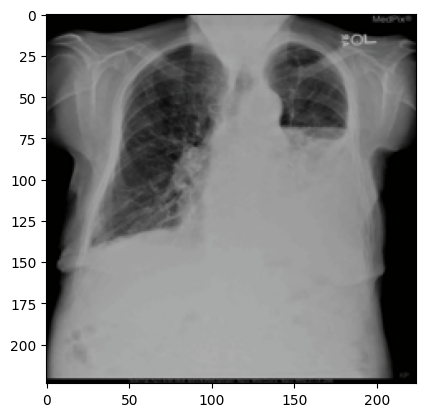

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

image_std = processor.image_processor.image_std
image_mean = processor.image_processor.image_mean

batch_idx = 1

unnormalized_image = (batch["pixel_values"][batch_idx].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)

print("Question: ",processor.decode(batch["input_ids"][batch_idx]))
print("Answer: ",processor.decode(batch["labels"][batch_idx]))
plt.imshow(Image.fromarray(unnormalized_image))

In [ ]:
from tqdm.notebook import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

model.train()
for epoch in range(200):
    print(f"Epoch: {epoch}")
    total_loss = []
    for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    print("Loss:", sum(total_loss))